In [48]:
import numpy as np
import os
import struct
import matplotlib.pyplot as plt


In [49]:
# This is code from the COLMAP git repository, no need to change anything here

def read_array(path):
    with open(path, "rb") as fid:
        width, height, channels = np.genfromtxt(
            fid, delimiter="&", max_rows=1, usecols=(0, 1, 2), dtype=int
        )
        fid.seek(0)
        num_delimiter = 0
        byte = fid.read(1)
        while True:
            if byte == b"&":
                num_delimiter += 1
                if num_delimiter >= 3:
                    break
            byte = fid.read(1)
        array = np.fromfile(fid, np.float32)
    array = array.reshape((width, height, channels), order="F")
    return np.transpose(array, (1, 0, 2)).squeeze()

def write_array(array, path):
    assert array.dtype == np.float32
    if len(array.shape) == 2:
        height, width = array.shape
        channels = 1
    elif len(array.shape) == 3:
        height, width, channels = array.shape
    else:
        assert False

    with open(path, "w") as fid:
        fid.write(str(width) + "&" + str(height) + "&" + str(channels) + "&")

    with open(path, "ab") as fid:
        if len(array.shape) == 2:
            array_trans = np.transpose(array, (1, 0))
        elif len(array.shape) == 3:
            array_trans = np.transpose(array, (1, 0, 2))
        else:
            assert False
        data_1d = array_trans.reshape(-1, order="F")
        data_list = data_1d.tolist()
        endian_character = "<"
        format_char_sequence = "".join(["f"] * len(data_list))
        byte_data = struct.pack(
            endian_character + format_char_sequence, *data_list
        )
        fid.write(byte_data)


In [50]:
# Set the file paths for the depth and normal maps
frame_number = "07851"
file_name = f"eastbound_20240319_{frame_number}.png.geometric.bin"

def get_depth_normal_map_paths(file_name):
    depth_map_path = 'depth/' + file_name  # Change this to your actual file path
    # depth_map_path = file_name  # Change this to your actual file path
    # normal_map_path = 'dense2/stereo/normal_maps/eastbound/' + file_name  # Change this to your actual file path
    return depth_map_path # , normal_map_path

depth_map_path = get_depth_normal_map_paths(file_name)

# Check if files exist
if not os.path.exists(depth_map_path):
    raise FileNotFoundError(f"File not found: {depth_map_path}")

# if not os.path.exists(normal_map_path):
#     raise FileNotFoundError(f"File not found: {normal_map_path}")

# Read depth and normal maps
depth_map = read_array(depth_map_path)
# normal_map = read_array(normal_map_path)

# Set the visualization parameters
min_depth_percentile = 5
max_depth_percentile = 95


In [51]:
# Todo: kinda obsolote but in theory this is the way to remove the outliers

# Set the visualization parameters
min_depth_percentile = 5
max_depth_percentile = 95

# Process the depth map based on percentiles
min_depth, max_depth = np.percentile(depth_map, [min_depth_percentile, max_depth_percentile])
print(f"min_depth: {min_depth}, max_depth: {max_depth}")
depth_map[depth_map < min_depth] = min_depth
depth_map[depth_map > max_depth] = max_depth


min_depth: 0.0, max_depth: 26.18873891830441


In [52]:
depth_map.shape

(1348, 2400)

In [53]:
import cv2

# Load the original 2D image and the depth map
original_image = cv2.imread('eastbound_20240319_07851.png')

original_image.shape

(1520, 2704, 3)

In [54]:
# Aspect ratio's are different but after resizing images overlap nicely

(1348/2400) / (1520/2704)

0.9991754385964913

In [55]:
# Resize the depth map to match the dimensions of the original image
# depth_map_resized = cv2.resize(depth_map, (original_image.shape[1], original_image.shape[0]))
depth_map_resized = cv2.resize(depth_map, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

depth_map = depth_map_resized

# Remove values that are too far from the camera and also set 0 values to NaN
# Replace zeros with NaNs for better visualization
depth_map[depth_map == 0] = np.nan
depth_map[depth_map > 5] = np.nan

C:\Users\lenov\AppData\Local\Temp\ipykernel_33424\2479737659.py:6: RuntimeWarning: invalid value encountered in cast
  depth_map_normalized = depth_map_normalized.astype(np.uint8)


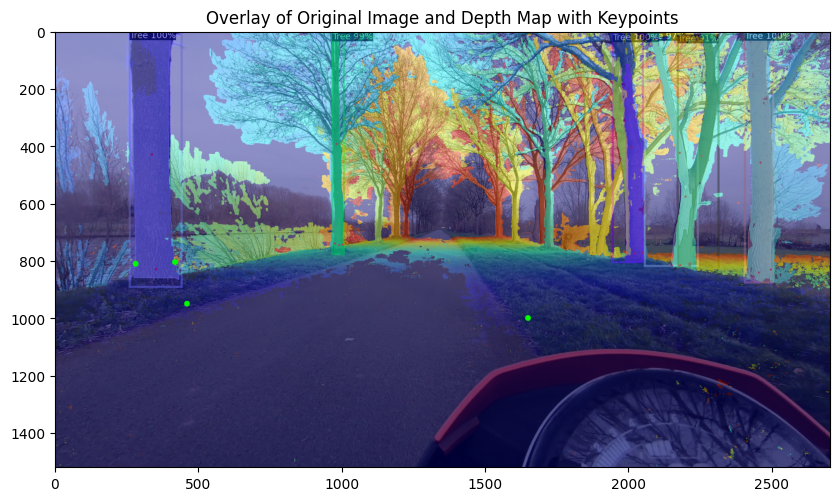

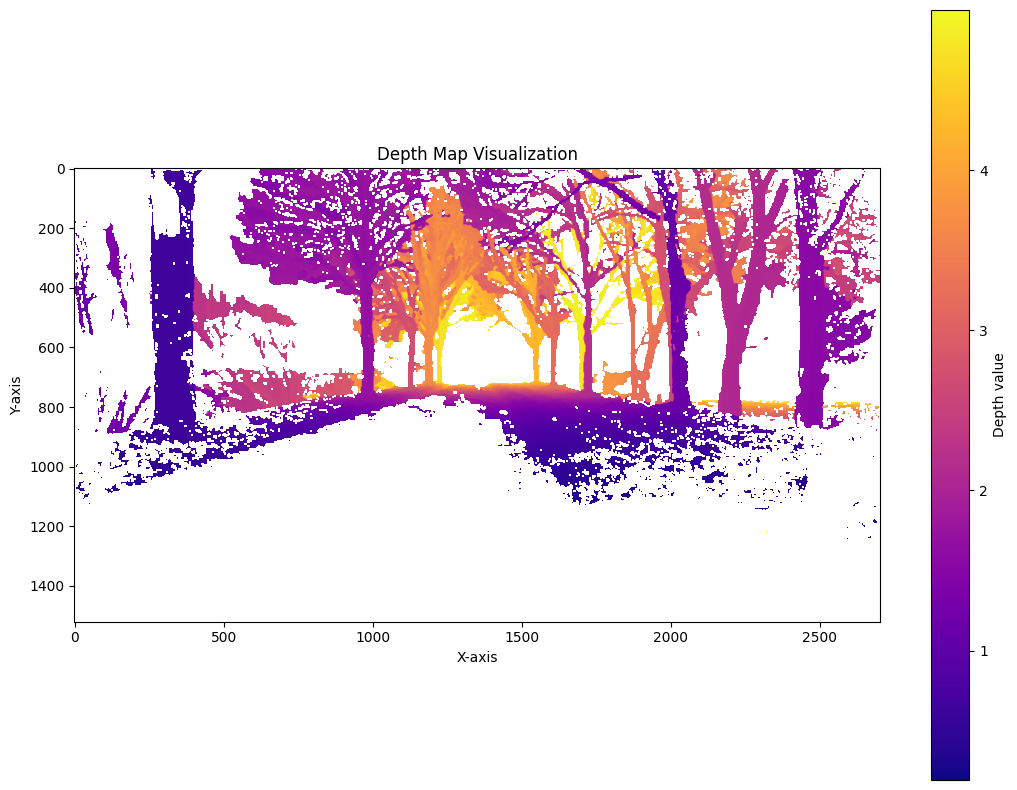

Mean Depth: 2.0029561519622803
Median Depth: 1.7506359815597534
Standard Deviation of Depth: 1.176411747932434


In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Normalize the depth map for visualization (optional)
depth_map_normalized = cv2.normalize(depth_map_resized, None, 0, 255, cv2.NORM_MINMAX)
depth_map_normalized = depth_map_normalized.astype(np.uint8)

# Convert depth map to a color map
depth_map_colored = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_JET)

# Overlay the depth map onto the original image
overlay = cv2.addWeighted(original_image, 0.6, depth_map_colored, 0.4, 0)

# Define keypoints (example coordinates)
left_point = (281, 811)
right_point = (418, 805)

# Points manually selected to estimate road width
road_left = (1650,1000)
road_right = (460,950)
keypoints = [
    left_point,
    right_point,
    road_left,
    road_right
]

# Add keypoints to the overlay image
for point in keypoints:
    cv2.circle(overlay, point, 10, (0, 255, 0), -1)

# Convert BGR image to RGB for displaying with matplotlib
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Display the overlay image with keypoints
plt.figure(figsize=(10, 10))
plt.imshow(overlay_rgb)
plt.title('Overlay of Original Image and Depth Map with Keypoints')
# plt.axis('off')
plt.show()

# Visualize the depth map
plt.figure(figsize=(13, 10))
plt.imshow(depth_map, cmap='plasma')
plt.colorbar(label='Depth value')
plt.title("Depth Map Visualization")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

# Compute basic statistics ignoring NaNs
mean_depth = np.nanmean(depth_map)
median_depth = np.nanmedian(depth_map)
std_depth = np.nanstd(depth_map)

print(f'Mean Depth: {mean_depth}')
print(f'Median Depth: {median_depth}')
print(f'Standard Deviation of Depth: {std_depth}')

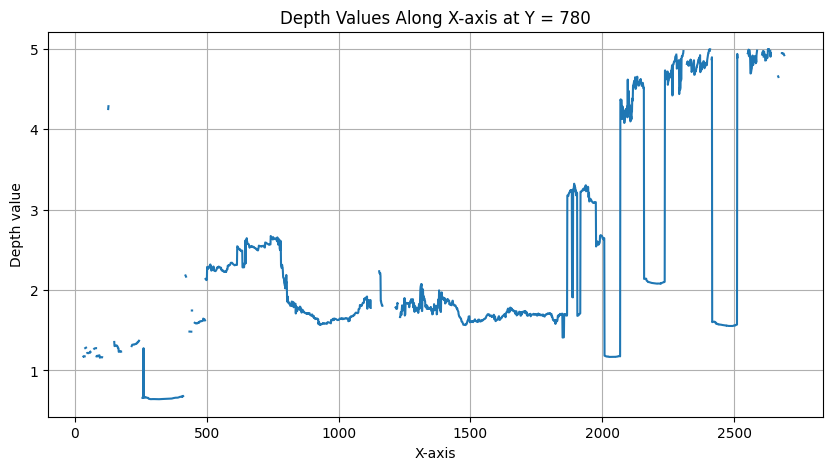

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Extract depth values along the x-axis for y = 600
y_value = 780
depth_values = depth_map[y_value, :]

# Plot the depth values
plt.figure(figsize=(10, 5))
plt.plot(depth_values)
plt.xlabel('X-axis')
plt.ylabel('Depth value')
plt.title(f'Depth Values Along X-axis at Y = {y_value}')
plt.grid(True)
plt.show()


In [58]:
depth_value = depth_map[780, 2480]
print(depth_value*100)

155.31476736068726


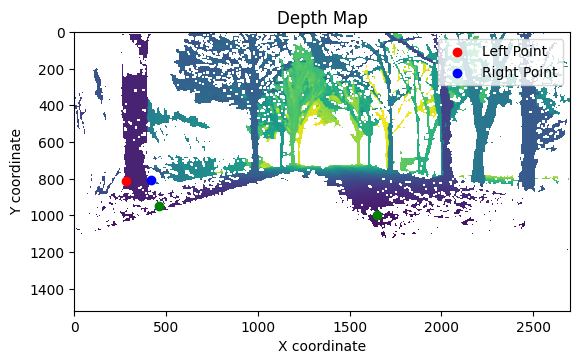

0.64343643 0.64633566 3.230429
[-0.47096803  0.02242705  0.63727752] [-2.06206986  0.09935026  3.08093858]
[ 1.59110184 -0.07692321 -2.44366106]
The width of the tree trunk is: 2.9170193058180076 units
2.9170193058180076
The width of the road trunk is: 2.9170193058180076 units


In [59]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_3d_coordinates_simple_radial(x, y, depth, fx, cx, cy, k1):
    """
    Convert pixel coordinates to world coordinates using the depth value and camera intrinsics.
    """
    X = (x - cx) * depth / fx
    Y = (y - cy) * depth / fx
    Z = depth / (1 + k1 * depth)
    # return X, Y, Z
    return np.array([X, Y, Z])

def compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1, depthm_override=False, d1=None, d2=None):
    x1, y1 = left_point
    x2, y2 = right_point
    
    mid_point = ((x1 + x2) // 2, (y1 + y2) // 2)
    xm = mid_point[0]
    ym = mid_point[1]
    
    depth1 = depth_map[y1, x1]
    depth2 = depth_map[y2, x2]
    depthm = depth_map[ym, xm]
    print(depth1, depthm, depth2)
    if depthm_override:
        if d1 is not None:
            depth1 = d1
        else:
            depth1 = depthm
        if d2 is not None:
            depth2 = d2
        else:
            depth2 = depthm        
        print(depth1, depthm, depth2)
    
    point1_3d = compute_3d_coordinates_simple_radial(x1, y1, depth1, fx, cx, cy, k1)
    point2_3d = compute_3d_coordinates_simple_radial(x2, y2, depth2, fx, cx, cy, k1)
    
    print(point1_3d, point2_3d)
    print(point1_3d - point2_3d)
    
    width = np.linalg.norm(point1_3d - point2_3d)
    return width



plt.imshow(depth_map)
plt.title('Depth Map')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

# Camera intrinsics
fx = 1463.2
cx = 1352
cy = 760
k1 = 0.01502

left_point = (281, 811)
right_point = (418, 805)

# left_point = (2415, 831)
# right_point = (2497, 831)
# left_point = (1993, 772)
# left_point = (2010, 773)
# right_point = (2050, 772)

plt.scatter(*left_point, color='red', label='Left Point')  # Scatter plot for left point
plt.scatter(*right_point, color='blue', label='Right Point')  # Scatter plot for right point
plt.scatter(1650,1000, color='green')  # Scatter plot for left point of road
plt.scatter(460,950, color='green')  # Scatter plot for right point of road

# plt.scatter(1550,800, color='red')
# plt.scatter(1500,800, color='red')
# plt.scatter(1550,750, color='red')
# plt.scatter(1500,750, color='red')

# Adding a legend to identify the points
plt.legend()
plt.show()

width = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1)
print(f"The width of the tree trunk is: {width} units")


# Function to compute the distance between two 3D points
def compute_distance(point1, point2):
    return np.linalg.norm(point1 - point2)


# Compute the midpoint
mid_point = ((left_point[0] + right_point[0]) // 2, (left_point[1] + right_point[1]) // 2)

# Get depth values
depth_left = depth_map[left_point[1], left_point[0]]
depth_right = depth_map[right_point[1], right_point[0]]
depth_mid = depth_map[mid_point[1], mid_point[0]]

# Compute 3D coordinates
point3d_left = compute_3d_coordinates_simple_radial(left_point[0], left_point[1], depth_left, fx, cx, cy, k1)
point3d_right = compute_3d_coordinates_simple_radial(right_point[0], right_point[1], depth_right, fx, cx, cy, k1)
point3d_mid = compute_3d_coordinates_simple_radial(mid_point[0], mid_point[1], depth_mid, fx, cx, cy, k1)

# Compute distances
width = compute_distance(point3d_left, point3d_right)
distance_to_mid = compute_distance(point3d_left, point3d_mid)

road_left = (1650,1000)
road_right = (460,950)

distance_roads = compute_distance(point3d_left, point3d_right)
print(distance_roads)

print(f"The width of the road trunk is: {distance_roads} units")



In [60]:


right_point = (1650,1000)
left_point = (460,950)
road_width = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1, depthm_override=False)
print(f"The width of the road is: {road_width} units")
units_per_meter = road_width / 4
print(f"Units per meter: {units_per_meter}")


left_point = (281, 811)
right_point = (418, 811)
width = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1, True)
print(f"The width of the tree trunk is: {width} units")
print(f"The width of the tree trunk is: {(width/units_per_meter)*100} centimeters")

0.58804935 nan 0.49559462
[-0.35848826  0.07635961  0.58290088] [0.10093439 0.08128944 0.49193276]
[-0.45942265 -0.00492983  0.09096812]
The width of the road is: 0.46836809511263255 units
Units per meter: 0.11709202377815814
0.64343643 0.64606327 1.4853189
0.64606327 0.64606327 0.64606327
[-0.47289076  0.02251861  0.63985421] [-0.4123996   0.02251861  0.63985421]
[-0.06049116  0.          0.        ]
The width of the tree trunk is: 0.06049116166026425 units
The width of the tree trunk is: 51.66121458014121 centimeters
